## Analiza skategoryzowana
---

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import norm
from scripts import StockDatabase, UtilsStockPrice
from sklearn.model_selection import train_test_split

### Prepare data

In [2]:
# Read all tickers for WIG_ODZIEZ sector
tickers = pd.read_csv("../database/designData/WIGs.csv")["WIG_ODZIEZ"].dropna()

# Load historical prices 
sdb = StockDatabase()
sdb.load_historical_data(tickers)
common_begin_date = sdb.get_common_begin_date()

# Read &  prepare reports database
report = pd.read_csv("../database/reportData/WIG_ODZIEZ_COMPANY_YY.csv", index_col=[0])
report["D_DATE"] = report["D_DATE"].astype("datetime64[s]")
report = report[report["D_DATE"] > common_begin_date]

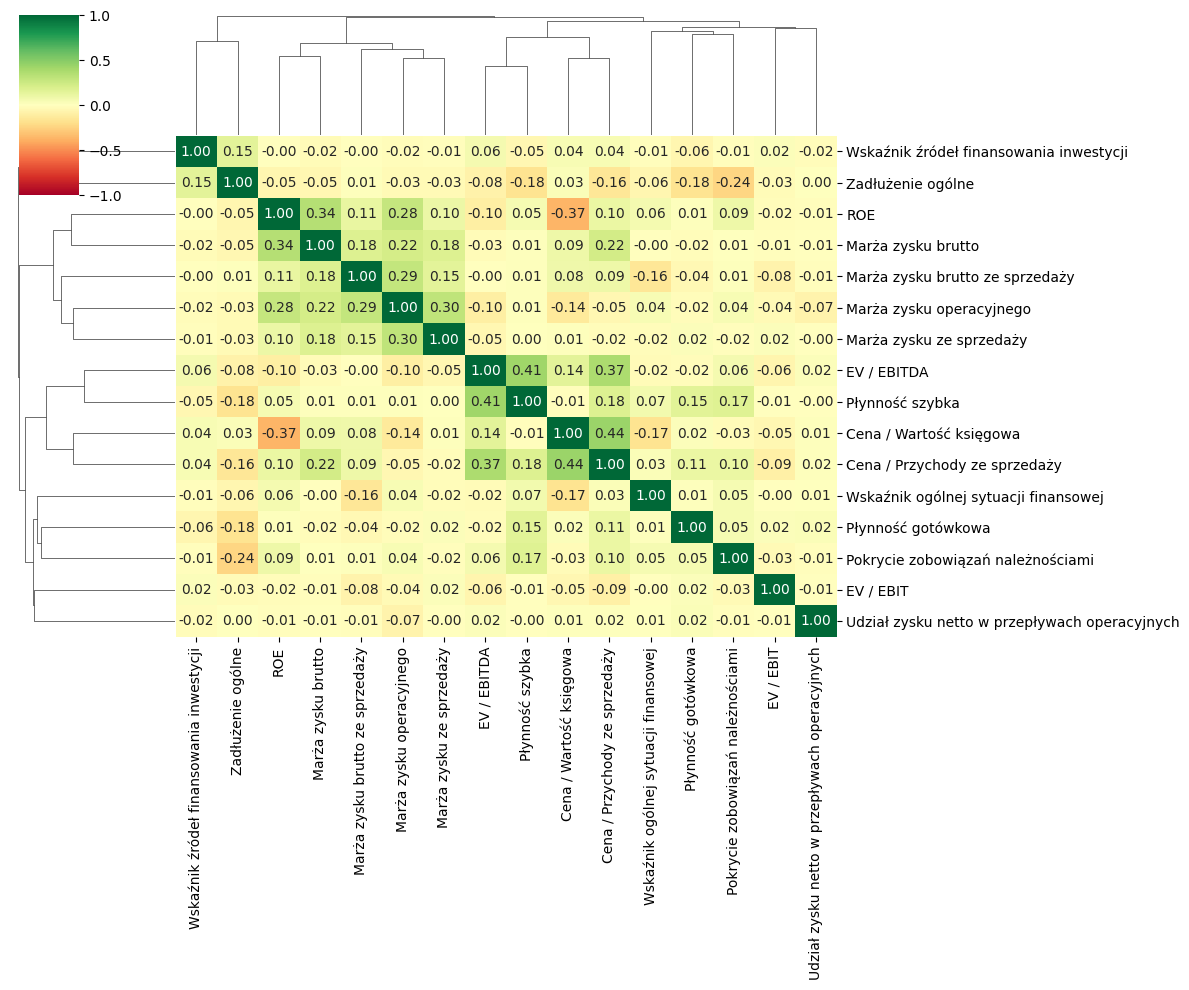

In [3]:
# Remove samples where sum(NaN feature) > 20% all feature (in sample)
report = report.dropna(axis = 0, thresh = report.shape[1] * 0.8)
# Remove feature where sum(NaN feature) > 20% all samples 
report = report.dropna(axis = 1, thresh = report.shape[0] * 0.8)

# Remove correlated feature 
CORRELATION_THRESHOLD = 0.65
corr_matrix = report.drop(columns=["D_DATE", "Ticker"]).corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > CORRELATION_THRESHOLD)]
report.drop(to_drop, axis=1, inplace=True)

# Display feature correlation
sns.clustermap(report.drop(columns=["D_DATE", "Ticker"]).corr(), 
               cmap='RdYlGn', vmin=-1, vmax=1, fmt='.2f', annot=True, figsize=(12, 10))
plt.show()

In [4]:
# Fill NaN value base on KNNImputer
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
report.iloc[:, 2:] = imputer.fit_transform(report.drop(columns=["D_DATE", "Ticker"]))

In [5]:
# Calculate reference returns (company_return - sector_return)
WINDOW_SIZE = 10
reference_return = []
for _, row in report.iterrows():
    date, ticker = row[:2]
    company_return = UtilsStockPrice.average_return(sdb.get_historical_data(ticker), date, window=WINDOW_SIZE)
    sector_return  = UtilsStockPrice.sector_average_return(sdb, date, to_omit=ticker, window=WINDOW_SIZE)
    reference_return.append(company_return - sector_return)

report.insert(0, "ReferenceReturn", reference_return)

In [7]:
# Remove outstanding data (they could be incorrect)
report = report[np.all([report["ReferenceReturn"] < report["ReferenceReturn"].mean() + 3 * report["ReferenceReturn"].std(), 
               report["ReferenceReturn"] > report["ReferenceReturn"].mean() - 3 * report["ReferenceReturn"].std()], axis=0)]

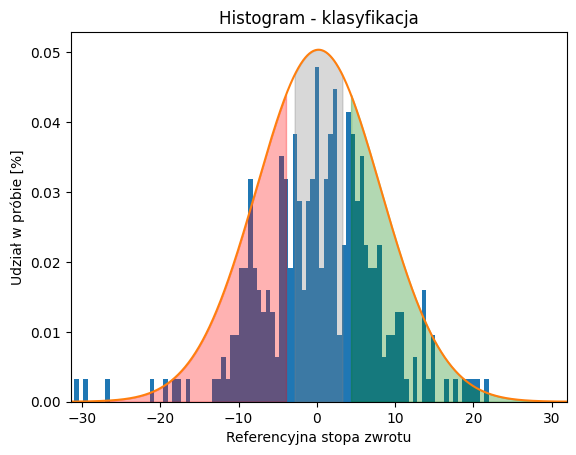

In [72]:
mean = report["ReferenceReturn"].mean()
std  = report["ReferenceReturn"].std() 


x_limits = [mean-4*std, mean+4*std] 
x = np.linspace(*x_limits, 1000)
percent_limits = norm.ppf([0, 0.3, 0.35, 0.65, 0.7, 1], loc=mean, scale=std)

plt.hist(report["ReferenceReturn"], bins=100,  weights=np.ones(len(report["ReferenceReturn"])) / len(report["ReferenceReturn"]))
plt.plot(x, norm.pdf(x, loc=mean, scale=std))
plt.fill_between(np.arange(x_limits[0], percent_limits[1], 1e-2), 
                 norm.pdf(np.arange(x_limits[0], percent_limits[1], 1e-2), loc=mean, scale=std), 
                 alpha = 0.3, color="red")
plt.fill_between(np.arange(percent_limits[2], percent_limits[3], 1e-2), 
                 norm.pdf(np.arange(percent_limits[2], percent_limits[3], 1e-2), loc=mean, scale=std), 
                 alpha = 0.3, color="grey")
plt.fill_between(np.arange(percent_limits[4], x_limits[1], 1e-2), 
                 norm.pdf(np.arange(percent_limits[4], x_limits[1], 1e-2), loc=mean, scale=std), 
                 alpha = 0.3, color="green")
plt.xlim(x_limits)
plt.title("Histogram - klasyfikacja")
plt.ylabel("Udział w próbie [%]")
plt.xlabel("Referencyjna stopa zwrotu")
plt.show()
